In [63]:
import requests
from datetime import datetime, timedelta
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import mcstest
from numpy.random import rand
from numpy import ix_

In [64]:
url = 'https://min-api.cryptocompare.com/data/v2/histohour?fsym=LTC&tsym=USD&limit=2000'
cryptocompare_api_key = 'e5137a810546baaa942a004f7090f2ace44c154138934ae6c2787539a9ad9ab4'

crypto_data = []
last_timestamp = datetime(2022, 4, 18).timestamp()
end_timestamp = datetime(2015, 1, 1).timestamp()

while last_timestamp > end_timestamp:
    response = requests.get(url + f'&toTs={last_timestamp - 1}' + '&api_key=' + cryptocompare_api_key)
    response_data = response.json()["Data"]["Data"]

    crypto_data = response_data + crypto_data
    last_timestamp = response_data[0]["time"]
    


In [65]:
timestamps = [point["time"] for point in crypto_data]
btc_prices = [point["close"] for point in crypto_data]
dates = [datetime.fromtimestamp(timestamp) for timestamp in timestamps]

btc_data = pd.DataFrame({
    "Timestamp": timestamps,
    "Date": dates,
    "Price": btc_prices
})

In [66]:
# btc_data = pd.read_csv("bitcoin.csv")
# btc_data

In [67]:
# btc_data["Date"] = btc_data["Date"].astype("datetime64")

In [68]:
# timestamps = btc_data["Timestamp"]
# dates =  btc_data["Date"]
# btc_prices = btc_data["Price"]

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'LiteCoin Price')]

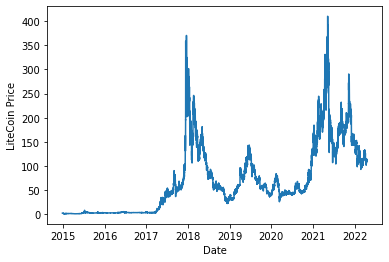

In [69]:
p = sns.lineplot(x = "Date", y = "Price", data = btc_data)
p.set(xlabel = "Date", ylabel = "LiteCoin Price")

In [70]:
btc_data["LogPrice"] = np.log(btc_data["Price"])
returns = btc_data["LogPrice"].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])
returns[0] = 0

btc_data["Return"] = returns 

In [71]:
start_first_day = 24
current_day = btc_data.Date[start_first_day]

while current_day.day != 1:
    start_first_day += 1
    current_day = btc_data.Date[start_first_day]

daily_rv = []
btc_prices_new = []

for i in range(start_first_day, len(btc_data) - 1, 24):
    mrv = 0

    for j in range(i - 24, i):
        mrv += (btc_data["Return"][j]) ** 2

    daily_rv.append(mrv * 100)
    btc_prices_new.append(btc_prices[i])

    

In [72]:
daily_dates = []

for tick in dates:
    if tick.date() not in daily_dates:
        daily_dates.append(tick.date())

In [73]:
while daily_dates[0] != current_day.date():
    daily_dates.pop(0)

In [74]:
weekly_rv = []

for i in range(len(daily_rv)):
    sum_daily_rv = 0
    cnt = 0

    for j in range(max(0, i - 6), i + 1):
        sum_daily_rv += daily_rv[j]
        cnt += 1
    
    weekly_rv.append(sum_daily_rv / cnt)

monthly_rv = []

for i in range(len(daily_rv)):
    sum_daily_rv = 0
    cnt = 0

    for j in range(max(0, i - 29), i + 1):
        sum_daily_rv += daily_rv[j]
        cnt += 1
    
    monthly_rv.append(sum_daily_rv / cnt)


[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Daily Realized Volatility')]

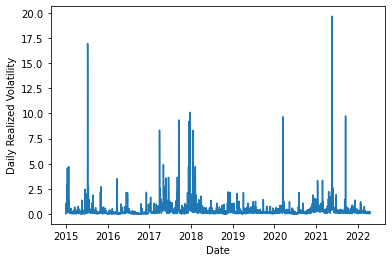

In [75]:
p = sns.lineplot(
    x=daily_dates,
    y=daily_rv
)
p.set(xlabel = "Date", ylabel = "Daily Realized Volatility")

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Weekly Realized Volatility')]

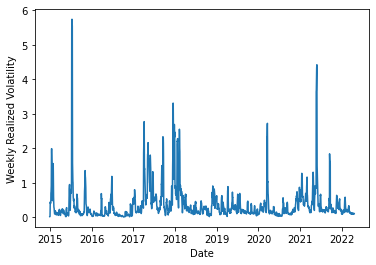

In [76]:
p = sns.lineplot(
    x=daily_dates,
    y=weekly_rv
)
p.set(xlabel = "Date", ylabel = "Weekly Realized Volatility")

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Monthly Realized Volatility')]

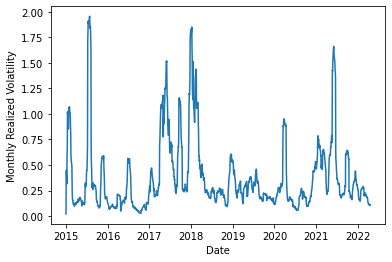

In [77]:
p = sns.lineplot(
    x=daily_dates,
    y=monthly_rv
)
p.set(xlabel = "Date", ylabel = "Monthly Realized Volatility")

In [78]:
# Базовая модель, h = 1
const_array = [1 for i in range(len(daily_rv))]
lag = 1

X_extended = pd.DataFrame({
    "Const": const_array[:-lag],
    "DailyRV": daily_rv[:-lag],
    "WeeklyRV": weekly_rv[:-lag],
    "MonthlyRV": monthly_rv[:-lag],
})

daily_rv_lag = daily_rv[lag:]

extended_har_rv = sm.OLS(daily_rv_lag, X_extended)
extended_har_rv = extended_har_rv.fit()

print(extended_har_rv.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     218.2
Date:                Sun, 22 May 2022   Prob (F-statistic):          1.62e-126
Time:                        20:50:54   Log-Likelihood:                -3137.3
No. Observations:                2663   AIC:                             6283.
Df Residuals:                    2659   BIC:                             6306.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const          0.1128      0.022      5.084      0.0

In [79]:
epu_data = pd.read_csv(r"/home/egorbi4/Загрузки/USEPUINDXD.csv")
epu_data["DATE"] = epu_data["DATE"].astype("datetime64")
epu_data

,DATE,USEPUINDXD
0,2012-01-01,419.03
1,2012-01-02,217.29
2,2012-01-03,200.32
3,2012-01-04,159.76
4,2012-01-05,92.24
...,...,...
3771,2022-04-29,126.85
3772,2022-04-30,293.99
3773,2022-05-01,143.71
3774,2022-05-02,109.19


In [80]:
start_data = 0

while epu_data["DATE"][start_data].date() != daily_dates[0]:
    start_data += 1

end_data = start_data

while epu_data["DATE"][end_data].date() != daily_dates[-1]:
    end_data += 1

epu_index = epu_data["USEPUINDXD"][start_data:end_data + 1]
epu_index = list(epu_index)

<AxesSubplot:>

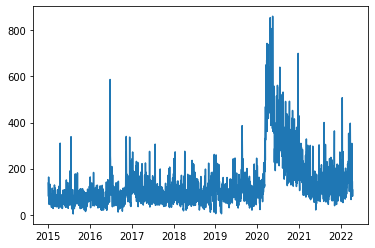

In [81]:
sns.lineplot(
    x = daily_dates,
    y = epu_index
)

In [82]:
daily_rv_lag_1 = daily_rv[1:] + daily_rv[-1:]
daily_rv_lag_7 = daily_rv[7:] + daily_rv[-7:]
daily_rv_lag_30 = daily_rv[30:] + daily_rv[-30:]

In [83]:
# Расширенная модель, h = 1
const_array = [1 for i in range(len(daily_rv))]
lag = 1

X_extended = pd.DataFrame({
    "Const": const_array[:-lag],
    "DailyRV": daily_rv[:-lag],
    "WeeklyRV": weekly_rv[:-lag],
    "MonthlyRV": monthly_rv[:-lag],
    "EPU": epu_index[:-lag]
})

daily_rv_lag = daily_rv[lag:]

extended_har_rv = sm.OLS(daily_rv_lag, X_extended)
extended_har_rv = extended_har_rv.fit()

print(extended_har_rv.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     163.7
Date:                Sun, 22 May 2022   Prob (F-statistic):          2.24e-125
Time:                        20:50:56   Log-Likelihood:                -3137.1
No. Observations:                2663   AIC:                             6284.
Df Residuals:                    2658   BIC:                             6314.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const          0.1233      0.029      4.208      0.0

In [84]:
# Расширенная модель, h = 7
lag = 6

X_extended = pd.DataFrame({
    "Const": const_array[:-lag],
    "DailyRV": daily_rv[:-lag],
    "WeeklyRV": weekly_rv[:-lag],
    "MonthlyRV": monthly_rv[:-lag],
    "EPU": epu_index[:-lag]
})

daily_rv_lag = daily_rv[lag:]

extended_har_rv = sm.OLS(daily_rv_lag, X_extended)
extended_har_rv = extended_har_rv.fit()

print(extended_har_rv.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     37.14
Date:                Sun, 22 May 2022   Prob (F-statistic):           2.90e-30
Time:                        20:50:56   Log-Likelihood:                -3353.1
No. Observations:                2658   AIC:                             6716.
Df Residuals:                    2653   BIC:                             6746.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const          0.2329      0.032      7.300      0.0

In [85]:
# Расширенная модель, h = 30
lag = 30

X_extended = pd.DataFrame({
    "Const": const_array[:-lag],
    "DailyRV": daily_rv[:-lag],
    "WeeklyRV": weekly_rv[:-lag],
    "MonthlyRV": monthly_rv[:-lag],
    "EPU": epu_index[:-lag]
})

daily_rv_lag = daily_rv[lag:]

extended_har_rv = sm.OLS(daily_rv_lag, X_extended)
extended_har_rv = extended_har_rv.fit()

print(extended_har_rv.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     7.817
Date:                Sun, 22 May 2022   Prob (F-statistic):           2.92e-06
Time:                        20:50:56   Log-Likelihood:                -3355.1
No. Observations:                2634   AIC:                             6720.
Df Residuals:                    2629   BIC:                             6750.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const          0.3321      0.032     10.253      0.0

In [86]:
vix_data = pd.read_csv(r"/home/egorbi4/Загрузки/VIXCLS.csv")
vix_data["DATE"] = vix_data["DATE"].astype("datetime64")
vix_data

,DATE,VIXCLS
0,2012-01-03,22.97
1,2012-01-04,22.22
2,2012-01-05,21.48
3,2012-01-06,20.63
4,2012-01-09,21.07
...,...,...
2695,2022-05-03,29.25
2696,2022-05-04,25.42
2697,2022-05-05,31.2
2698,2022-05-06,30.19


In [87]:
dates_without_weekend = []
daily_rv_without_weekend = []
weekly_rv_without_weekend = []
monthly_rv_without_weekend = []
epu_without_weekend = []
btc_prices_without_weekend = []

for ind in range(len(daily_dates)):
    if daily_dates[ind].weekday() < 5:
        dates_without_weekend.append(daily_dates[ind])
        daily_rv_without_weekend.append(daily_rv[ind])
        weekly_rv_without_weekend.append(weekly_rv[ind])
        monthly_rv_without_weekend.append(monthly_rv[ind])
        epu_without_weekend.append(epu_index[ind])
        btc_prices_without_weekend.append(btc_prices_new[ind])
    


In [88]:
start_data = 0

while vix_data["DATE"][start_data].date() != dates_without_weekend[0]:
    start_data += 1

end_data = start_data

while vix_data["DATE"][end_data].date() != dates_without_weekend[-1]:
    end_data += 1

vix_index = vix_data["VIXCLS"][start_data:end_data + 1]

In [89]:
vix_index = list(vix_index)
vix_index[0] = vix_index[1] if vix_index[0] == "." else vix_index[0]

for ind in range(len(vix_index)):
    if vix_index[ind] == '.':
        vix_index[ind] = vix_index[ind - 1]
    
    vix_index[ind] = float(vix_index[ind])

vix_index

[17.79,
 17.79,
 19.92,
 21.12,
 19.31,
 17.01,
 17.55,
 19.6,
 20.56,
 21.48,
 22.39,
 20.95,
 20.95,
 19.89,
 18.85,
 16.4,
 16.66,
 15.52,
 17.22,
 20.44,
 18.76,
 20.97,
 19.43,
 17.33,
 18.33,
 16.85,
 17.29,
 18.55,
 17.23,
 16.96,
 15.34,
 14.69,
 14.69,
 15.8,
 15.45,
 15.29,
 14.3,
 14.56,
 13.69,
 13.84,
 13.91,
 13.34,
 13.04,
 13.86,
 14.23,
 14.04,
 15.2,
 15.06,
 16.69,
 16.87,
 15.42,
 16.0,
 15.61,
 15.66,
 13.97,
 14.07,
 13.02,
 13.41,
 13.62,
 15.44,
 15.8,
 15.07,
 14.51,
 15.29,
 15.11,
 14.67,
 14.67,
 14.74,
 14.78,
 13.98,
 13.09,
 12.58,
 13.94,
 13.67,
 12.84,
 12.6,
 13.89,
 13.3,
 13.25,
 12.71,
 12.48,
 12.29,
 13.12,
 12.41,
 13.39,
 14.55,
 12.7,
 12.85,
 14.31,
 15.15,
 15.13,
 12.86,
 13.85,
 13.86,
 13.76,
 12.74,
 12.38,
 12.73,
 12.85,
 12.88,
 12.11,
 12.13,
 12.13,
 14.06,
 13.27,
 13.31,
 13.84,
 13.97,
 14.24,
 13.66,
 14.71,
 14.21,
 15.29,
 14.47,
 13.22,
 12.85,
 13.78,
 15.39,
 14.81,
 14.5,
 13.19,
 13.96,
 12.74,
 12.11,
 13.26,
 14.01,
 14

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'VIX')]

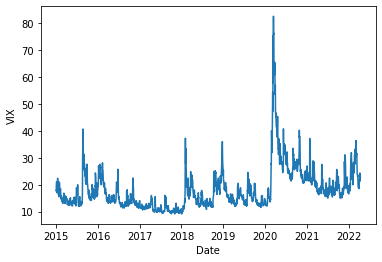

In [90]:
p = sns.lineplot(
    x = dates_without_weekend,
    y = vix_index,
)

p.set(xlabel = "Date", ylabel = "VIX")

In [91]:
# Расширенная модель с VIX, h = 1
const_array = [1 for i in range(len(daily_rv_without_weekend))]
lag = 1

X_extended = pd.DataFrame({
    "Const": const_array[:-lag],
    "DailyRV": daily_rv_without_weekend[:-lag],
    "WeeklyRV": weekly_rv_without_weekend[:-lag],
    "MonthlyRV": monthly_rv_without_weekend[:-lag],
    "VIX": vix_index[:-lag]
})

daily_rv_lag = daily_rv_without_weekend[lag:]

extended_har_rv = sm.OLS(daily_rv_lag, X_extended)
extended_har_rv = extended_har_rv.fit()

print(extended_har_rv.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     69.95
Date:                Sun, 22 May 2022   Prob (F-statistic):           2.61e-55
Time:                        20:50:58   Log-Likelihood:                -2075.2
No. Observations:                1901   AIC:                             4160.
Df Residuals:                    1896   BIC:                             4188.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const          0.1175      0.046      2.545      0.0

In [92]:
# Расширенная модель с VIX, h = 6
const_array = [1 for i in range(len(daily_rv_without_weekend))]
lag = 6

X_extended = pd.DataFrame({
    "Const": const_array[:-lag],
    "DailyRV": daily_rv_without_weekend[:-lag],
    "WeeklyRV": weekly_rv_without_weekend[:-lag],
    "MonthlyRV": monthly_rv_without_weekend[:-lag],
    "VIX": vix_index[:-lag]
})

daily_rv_lag = daily_rv_without_weekend[lag:]

extended_har_rv = sm.OLS(daily_rv_lag, X_extended)
extended_har_rv = extended_har_rv.fit()

print(extended_har_rv.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     20.24
Date:                Sun, 22 May 2022   Prob (F-statistic):           2.41e-16
Time:                        20:50:58   Log-Likelihood:                -2162.4
No. Observations:                1896   AIC:                             4335.
Df Residuals:                    1891   BIC:                             4362.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const          0.2563      0.048      5.288      0.0

In [93]:
# Расширенная модель с VIX, h = 30
const_array = [1 for i in range(len(daily_rv_without_weekend))]
lag = 30

X_extended = pd.DataFrame({
    "Const": const_array[:-lag],
    "DailyRV": daily_rv_without_weekend[:-lag],
    "WeeklyRV": weekly_rv_without_weekend[:-lag],
    "MonthlyRV": monthly_rv_without_weekend[:-lag],
    "VIX": vix_index[:-lag]
})

daily_rv_lag = daily_rv_without_weekend[lag:]

extended_har_rv = sm.OLS(daily_rv_lag, X_extended)
extended_har_rv = extended_har_rv.fit()

print(extended_har_rv.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     6.836
Date:                Sun, 22 May 2022   Prob (F-statistic):           1.85e-05
Time:                        20:50:58   Log-Likelihood:                -2134.5
No. Observations:                1872   AIC:                             4279.
Df Residuals:                    1867   BIC:                             4307.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const          0.4593      0.049      9.455      0.0

In [94]:
# Расширенная модель с VIX и EPU, h = 1
const_array = [1 for i in range(len(daily_rv_without_weekend))]
lag = 1

X_extended = pd.DataFrame({
    "Const": const_array[:-lag],
    "DailyRV": daily_rv_without_weekend[:-lag],
    "WeeklyRV": weekly_rv_without_weekend[:-lag],
    "MonthlyRV": monthly_rv_without_weekend[:-lag],
    "VIX": vix_index[:-lag],
    "EPU": epu_without_weekend[:-lag]
})

daily_rv_lag = daily_rv_without_weekend[lag:]

extended_har_rv = sm.OLS(daily_rv_lag, X_extended)
extended_har_rv = extended_har_rv.fit()

print(extended_har_rv.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     56.14
Date:                Sun, 22 May 2022   Prob (F-statistic):           1.47e-54
Time:                        20:50:59   Log-Likelihood:                -2074.7
No. Observations:                1901   AIC:                             4161.
Df Residuals:                    1895   BIC:                             4195.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const          0.1116      0.047      2.399      0.0

In [95]:
# Расширенная модель с VIX и EPU, h = 6
const_array = [1 for i in range(len(daily_rv_without_weekend))]
lag = 6

X_extended = pd.DataFrame({
    "Const": const_array[:-lag],
    "DailyRV": daily_rv_without_weekend[:-lag],
    "WeeklyRV": weekly_rv_without_weekend[:-lag],
    "MonthlyRV": monthly_rv_without_weekend[:-lag],
    "VIX": vix_index[:-lag],
    "EPU": epu_without_weekend[:-lag]
})

daily_rv_lag = daily_rv_without_weekend[lag:]

extended_har_rv = sm.OLS(daily_rv_lag, X_extended)
extended_har_rv = extended_har_rv.fit()

print(extended_har_rv.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     16.45
Date:                Sun, 22 May 2022   Prob (F-statistic):           6.40e-16
Time:                        20:50:59   Log-Likelihood:                -2161.7
No. Observations:                1896   AIC:                             4335.
Df Residuals:                    1890   BIC:                             4369.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const          0.2492      0.049      5.099      0.0

In [96]:
# Расширенная модель с VIX и EPU, h = 30
const_array = [1 for i in range(len(daily_rv_without_weekend))]
lag = 30

X_extended = pd.DataFrame({
    "Const": const_array[:-lag],
    "DailyRV": daily_rv_without_weekend[:-lag],
    "WeeklyRV": weekly_rv_without_weekend[:-lag],
    "MonthlyRV": monthly_rv_without_weekend[:-lag],
    "VIX": vix_index[:-lag],
    "EPU": epu_without_weekend[:-lag]
})

daily_rv_lag = daily_rv_without_weekend[lag:]

extended_har_rv = sm.OLS(daily_rv_lag, X_extended)
extended_har_rv = extended_har_rv.fit()

print(extended_har_rv.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     5.970
Date:                Sun, 22 May 2022   Prob (F-statistic):           1.74e-05
Time:                        20:50:59   Log-Likelihood:                -2133.3
No. Observations:                1872   AIC:                             4279.
Df Residuals:                    1866   BIC:                             4312.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const          0.4696      0.049      9.585      0.0

In [97]:
oil_data = pd.read_csv(r"/home/egorbi4/Загрузки/OVXCLS.csv")
oil_data["DATE"] = oil_data["DATE"].astype("datetime64")
oil_data

,DATE,OVXCLS
0,2012-01-03,40.07
1,2012-01-04,39.04
2,2012-01-05,38.70
3,2012-01-06,37.12
4,2012-01-09,36.52
...,...,...
2696,2022-05-04,53.15
2697,2022-05-05,54.72
2698,2022-05-06,54.82
2699,2022-05-09,57.9


In [98]:
start_data = 0

while oil_data["DATE"][start_data].date() != dates_without_weekend[0]:
    start_data += 1

end_data = start_data

while oil_data["DATE"][end_data].date() != dates_without_weekend[-1]:
    end_data += 1

oil_index = oil_data["OVXCLS"][start_data:end_data + 1]

In [99]:
oil_index = list(oil_index)
oil_index[0] = oil_index[1] if oil_index[0] == "." else oil_index[0]

for ind in range(len(oil_index)):
    if oil_index[ind] == '.':
        oil_index[ind] = oil_index[ind - 1]
    
    oil_index[ind] = float(oil_index[ind])

oil_index

[54.25,
 54.25,
 57.67,
 56.45,
 53.25,
 50.96,
 50.07,
 53.13,
 53.78,
 53.17,
 57.77,
 56.44,
 56.44,
 57.99,
 55.09,
 56.4,
 57.62,
 56.65,
 54.23,
 55.18,
 54.69,
 58.62,
 57.84,
 59.68,
 62.73,
 63.14,
 60.83,
 56.0,
 59.29,
 60.23,
 58.69,
 55.53,
 55.53,
 56.33,
 55.97,
 55.75,
 54.0,
 58.67,
 56.27,
 54.93,
 56.46,
 55.85,
 54.92,
 53.05,
 48.92,
 47.09,
 48.96,
 48.99,
 50.92,
 49.17,
 49.59,
 54.56,
 56.93,
 59.85,
 53.65,
 53.82,
 50.84,
 49.32,
 47.94,
 47.03,
 49.58,
 52.84,
 51.98,
 53.72,
 50.9,
 49.84,
 49.84,
 48.33,
 46.25,
 48.1,
 46.65,
 43.04,
 44.2,
 44.65,
 46.14,
 43.48,
 42.0,
 42.06,
 41.04,
 39.01,
 37.98,
 36.61,
 37.46,
 37.31,
 36.68,
 36.28,
 35.62,
 36.2,
 36.24,
 36.88,
 38.13,
 35.09,
 34.86,
 33.74,
 34.33,
 32.63,
 29.95,
 30.63,
 34.82,
 33.7,
 31.61,
 31.29,
 31.29,
 34.66,
 35.29,
 34.2,
 33.74,
 35.3,
 35.74,
 37.4,
 38.42,
 33.54,
 34.04,
 33.01,
 31.79,
 31.76,
 31.51,
 32.55,
 32.39,
 32.83,
 31.59,
 30.4,
 30.06,
 29.69,
 29.6,
 29.26,
 29.01

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'OVX')]

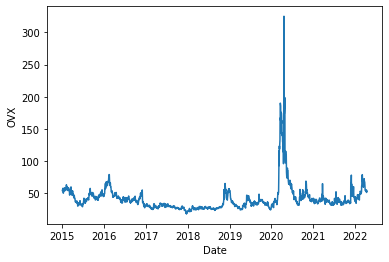

In [100]:
p = sns.lineplot(
    x = dates_without_weekend,
    y = oil_index
)

p.set(xlabel = "Date", ylabel="OVX")

In [101]:
# Расширенная модель с VIX и EPU, h = 1
const_array = [1 for i in range(len(daily_rv_without_weekend))]
lag = 1

X_extended = pd.DataFrame({
    "Const": const_array[:-lag],
    "DailyRV": daily_rv_without_weekend[:-lag],
    "WeeklyRV": weekly_rv_without_weekend[:-lag],
    "MonthlyRV": monthly_rv_without_weekend[:-lag],
    "VIX": vix_index[:-lag],
    "EPU": epu_without_weekend[:-lag],
    "OVX": oil_index[:-lag],
})

daily_rv_lag = daily_rv_without_weekend[lag:]

extended_har_rv = sm.OLS(daily_rv_lag, X_extended)
extended_har_rv = extended_har_rv.fit()

print(extended_har_rv.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     48.06
Date:                Sun, 22 May 2022   Prob (F-statistic):           4.10e-55
Time:                        20:51:00   Log-Likelihood:                -2071.3
No. Observations:                1901   AIC:                             4157.
Df Residuals:                    1894   BIC:                             4196.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const          0.1332      0.047      2.822      0.0

In [102]:
# Расширенная модель с VIX и EPU, h = 1
const_array = [1 for i in range(len(daily_rv_without_weekend))]
lag = 6

X_extended = pd.DataFrame({
    "Const": const_array[:-lag],
    "DailyRV": daily_rv_without_weekend[:-lag],
    "WeeklyRV": weekly_rv_without_weekend[:-lag],
    "MonthlyRV": monthly_rv_without_weekend[:-lag],
    "VIX": vix_index[:-lag],
    "EPU": epu_without_weekend[:-lag],
    "OVX": oil_index[:-lag],
})

daily_rv_lag = daily_rv_without_weekend[lag:]

extended_har_rv = sm.OLS(daily_rv_lag, X_extended)
extended_har_rv = extended_har_rv.fit()

print(extended_har_rv.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     14.85
Date:                Sun, 22 May 2022   Prob (F-statistic):           1.19e-16
Time:                        20:51:01   Log-Likelihood:                -2158.4
No. Observations:                1896   AIC:                             4331.
Df Residuals:                    1889   BIC:                             4370.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const          0.2714      0.050      5.477      0.0

In [103]:
gold_data = pd.read_csv(r"/home/egorbi4/Загрузки/GVZCLS.csv")
gold_data["DATE"] = gold_data["DATE"].astype("datetime64")
gold_data

,DATE,GVZCLS
0,2012-01-03,22.90
1,2012-01-04,22.08
2,2012-01-05,22.34
3,2012-01-06,21.30
4,2012-01-09,21.47
...,...,...
2696,2022-05-04,18.81
2697,2022-05-05,19.36
2698,2022-05-06,18.71
2699,2022-05-09,20.49


In [104]:
start_data = 0

while gold_data["DATE"][start_data].date() != dates_without_weekend[0]:
    start_data += 1

end_data = start_data

while gold_data["DATE"][end_data].date() != dates_without_weekend[-1]:
    end_data += 1

gold_index = gold_data["GVZCLS"][start_data:end_data + 1]

In [105]:
gold_index = list(gold_index)
gold_index[0] = gold_index[1] if gold_index[0] == "." else gold_index[0]

for ind in range(len(gold_index)):
    if gold_index[ind] == '.':
        gold_index[ind] = gold_index[ind - 1]
    
    gold_index[ind] = float(gold_index[ind])

gold_index

[20.23,
 20.23,
 21.26,
 20.78,
 20.35,
 19.2,
 18.44,
 17.65,
 17.63,
 18.52,
 21.83,
 22.66,
 22.66,
 23.43,
 22.34,
 21.25,
 20.62,
 20.04,
 20.16,
 19.31,
 20.25,
 19.65,
 20.33,
 20.3,
 20.36,
 20.06,
 20.59,
 20.3,
 19.71,
 20.07,
 19.31,
 18.49,
 18.49,
 19.61,
 19.54,
 18.62,
 19.26,
 19.4,
 18.77,
 17.4,
 16.65,
 15.91,
 16.38,
 16.76,
 16.66,
 16.9,
 18.43,
 17.58,
 18.97,
 20.01,
 19.07,
 18.9,
 19.14,
 20.83,
 18.65,
 17.25,
 17.21,
 17.26,
 16.84,
 16.38,
 16.02,
 15.83,
 16.64,
 16.34,
 16.04,
 16.01,
 16.01,
 15.74,
 15.2,
 14.79,
 15.0,
 14.23,
 14.79,
 15.18,
 14.6,
 14.54,
 14.47,
 15.39,
 15.04,
 15.79,
 15.87,
 16.39,
 16.42,
 16.19,
 15.95,
 16.76,
 17.29,
 17.62,
 17.15,
 17.53,
 17.91,
 15.84,
 15.94,
 15.63,
 15.93,
 16.21,
 15.48,
 15.81,
 15.88,
 15.25,
 14.62,
 14.19,
 14.19,
 15.22,
 14.08,
 14.51,
 13.99,
 14.88,
 14.86,
 15.15,
 16.01,
 15.12,
 15.14,
 14.83,
 14.37,
 14.3,
 13.99,
 14.34,
 14.36,
 13.58,
 13.53,
 13.26,
 13.85,
 13.89,
 13.83,
 13.12,
 13

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'GVZ')]

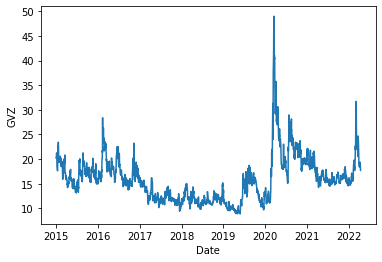

In [106]:
p = sns.lineplot(
    x = dates_without_weekend,
    y = gold_index,
)

p.set(xlabel = "Date", ylabel = "GVZ")

In [107]:
start = 1100
end = 1700

d = daily_rv_without_weekend[start:end]
w = weekly_rv_without_weekend[start:end]
m = monthly_rv_without_weekend[start:end]
gold = gold_index[start:end]
const_array = [1 for i in range(len(d))]

X_extended = pd.DataFrame({
    "Const": const_array[:-lag],
    "DailyRV": d[:-lag],
    "WeeklyRV": w[:-lag],
    "MonthlyRV": m[:-lag],
    # "VIX": vix_index[:-lag],
    # "EPU": epu_without_weekend[:-lag],
    # "OIL": oil_index[:-lag],
    # "GOLD": gold[:-lag],
})

daily_rv_lag = d[lag:]

extended_har_rv = sm.OLS(daily_rv_lag, X_extended)
extended_har_rv = extended_har_rv.fit()

print(extended_har_rv.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     3.799
Date:                Sun, 22 May 2022   Prob (F-statistic):             0.0102
Time:                        20:51:02   Log-Likelihood:                -782.90
No. Observations:                 594   AIC:                             1574.
Df Residuals:                     590   BIC:                             1591.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const          0.2270      0.057      3.966      0.0

In [108]:
# Расширенная модель с VIX и EPU, h = 1
const_array = [1 for i in range(len(daily_rv_without_weekend))]
lag = 1

X_extended = pd.DataFrame({
    "Const": const_array[:-lag],
    "DailyRV": daily_rv_without_weekend[:-lag],
    "WeeklyRV": weekly_rv_without_weekend[:-lag],
    "MonthlyRV": monthly_rv_without_weekend[:-lag],
    # "VIX": vix_index[:-lag],
    # "EPU": epu_without_weekend[:-lag],
    # "OIL": oil_index[:-lag],
    "GOLD": gold_index[:-lag],
})

daily_rv_lag = daily_rv_without_weekend[lag:]

extended_har_rv = sm.OLS(daily_rv_lag, X_extended)
extended_har_rv = extended_har_rv.fit()

print(extended_har_rv.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     70.15
Date:                Sun, 22 May 2022   Prob (F-statistic):           1.85e-55
Time:                        20:51:03   Log-Likelihood:                -2074.9
No. Observations:                1901   AIC:                             4160.
Df Residuals:                    1896   BIC:                             4187.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const          0.1987      0.064      3.120      0.0

<AxesSubplot:>

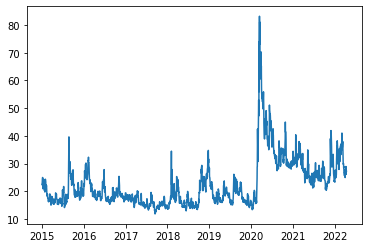

In [109]:
russel_data = pd.read_csv(r"/home/egorbi4/Загрузки/RVXCLS.csv")
russel_data["DATE"] = russel_data["DATE"].astype("datetime64")

start_data = 0

while russel_data["DATE"][start_data].date() != dates_without_weekend[0]:
    start_data += 1

end_data = start_data

while russel_data["DATE"][end_data].date() != dates_without_weekend[-1]:
    end_data += 1

russel_index = russel_data["RVXCLS"][start_data:end_data + 1]

russel_index = list(russel_index)
russel_index[0] = russel_index[1] if russel_index[0] == "." else russel_index[0]

for ind in range(len(russel_index)):
    if russel_index[ind] == '.':
        russel_index[ind] = russel_index[ind - 1]
    
    russel_index[ind] = float(russel_index[ind])

sns.lineplot(
    x = dates_without_weekend,
    y = russel_index
)

In [110]:
# Расширенная модель с VIX и EPU, h = 1
const_array = [1 for i in range(len(daily_rv_without_weekend))]
lag = 1

X_extended = pd.DataFrame({
    "Const": const_array[:-lag],
    "DailyRV": daily_rv_without_weekend[:-lag],
    "WeeklyRV": weekly_rv_without_weekend[:-lag],
    "MonthlyRV": monthly_rv_without_weekend[:-lag],
    "VIX": vix_index[:-lag],
    "EPU": epu_without_weekend[:-lag],
    "OIL": oil_index[:-lag],
    "GOLD": gold_index[:-lag],
    "RUSSEL": russel_index[:-lag],
})

daily_rv_lag = daily_rv_without_weekend[lag:]

extended_har_rv = sm.OLS(daily_rv_lag, X_extended)
extended_har_rv = extended_har_rv.fit()

print(extended_har_rv.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     36.35
Date:                Sun, 22 May 2022   Prob (F-statistic):           6.26e-54
Time:                        20:51:04   Log-Likelihood:                -2070.2
No. Observations:                1901   AIC:                             4158.
Df Residuals:                    1892   BIC:                             4208.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const          0.1708      0.068      2.522      0.0

<AxesSubplot:>

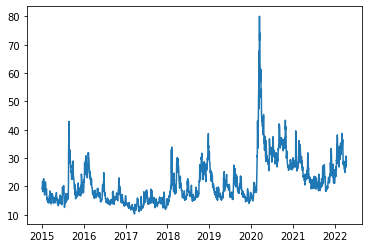

In [111]:
nasdaq_data = pd.read_csv(r"/home/egorbi4/Загрузки/VXNCLS.csv")
nasdaq_data["DATE"] = nasdaq_data["DATE"].astype("datetime64")

start_data = 0

while nasdaq_data["DATE"][start_data].date() != dates_without_weekend[0]:
    start_data += 1

end_data = start_data

while nasdaq_data["DATE"][end_data].date() != dates_without_weekend[-1]:
    end_data += 1

nasdaq_index = nasdaq_data["VXNCLS"][start_data:end_data + 1]

nasdaq_index = list(nasdaq_index)
nasdaq_index[0] = nasdaq_index[1] if nasdaq_index[0] == "." else nasdaq_index[0]

for ind in range(len(nasdaq_index)):
    if nasdaq_index[ind] == '.':
        nasdaq_index[ind] = nasdaq_index[ind - 1]
    
    nasdaq_index[ind] = float(nasdaq_index[ind])

sns.lineplot(
    x = dates_without_weekend,
    y = nasdaq_index
)

In [112]:
# Расширенная модель с VIX и EPU, h = 1
const_array = [1 for i in range(len(daily_rv_without_weekend))]
lag = 30

X_extended = pd.DataFrame({
    "Const": const_array[:-lag],
    "DailyRV": daily_rv_without_weekend[:-lag],
    "WeeklyRV": weekly_rv_without_weekend[:-lag],
    "MonthlyRV": monthly_rv_without_weekend[:-lag],
    "VIX": vix_index[:-lag],
    "EPU": epu_without_weekend[:-lag],
    "OIL": oil_index[:-lag],
    "GOLD": gold_index[:-lag],
    "RUSSEL": russel_index[:-lag],
    "NASDAQ": nasdaq_index[:-lag],
})

daily_rv_lag = daily_rv_without_weekend[lag:]

extended_har_rv = sm.OLS(daily_rv_lag, X_extended)
extended_har_rv = extended_har_rv.fit()

print(extended_har_rv.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     7.141
Date:                Sun, 22 May 2022   Prob (F-statistic):           3.09e-10
Time:                        20:51:05   Log-Likelihood:                -2116.4
No. Observations:                1872   AIC:                             4253.
Df Residuals:                    1862   BIC:                             4308.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const          0.4853      0.082      5.927      0.0

/tmp/ipykernel_19586/1315135334.py:29: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if djia_dates[i] != dates_without_weekend[i]:


[Text(0.5, 0, 'Date'), Text(0, 0.5, 'VXD')]

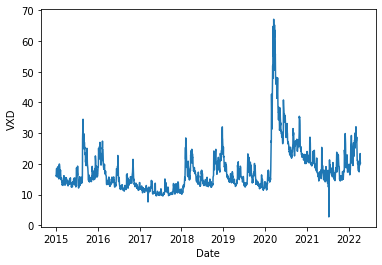

In [113]:
djia_data = pd.read_csv(r"/home/egorbi4/Загрузки/VXDCLS.csv")
djia_data["DATE"] = djia_data["DATE"].astype("datetime64")

start_data = 0

while djia_data["DATE"][start_data].date() != dates_without_weekend[0]:
    start_data += 1

end_data = start_data

while djia_data["DATE"][end_data].date() != dates_without_weekend[-1]:
    end_data += 1

djia_index = djia_data["VXDCLS"][start_data:end_data + 1]
djia_dates = list(djia_data["DATE"][start_data:end_data + 1])

djia_index = list(djia_index)
djia_index[0] = djia_index[1] if djia_index[0] == "." else djia_index[0]

for ind in range(len(djia_index)):
    if djia_index[ind] == '.':
        djia_index[ind] = djia_index[ind - 1]
    
    djia_index[ind] = float(djia_index[ind])

breaking_index = None

for i in range(len(djia_dates)):
    if djia_dates[i] != dates_without_weekend[i]:
        breaking_index = i
        break

if breaking_index:
    djia_index.pop(breaking_index)

p = sns.lineplot(
    x = dates_without_weekend,
    y = djia_index
)

p.set(xlabel = "Date", ylabel="VXD")

In [119]:
# Расширенная модель с VIX и EPU, h = 1
const_array = [1 for i in range(len(daily_rv_without_weekend))]
lag = 1

X_extended = pd.DataFrame({
    "Const": const_array[:-lag],
    "DailyRV": daily_rv_without_weekend[:-lag],
    "WeeklyRV": weekly_rv_without_weekend[:-lag],
    "MonthlyRV": monthly_rv_without_weekend[:-lag],
    # "VIX": vix_index[:-lag],
    # "EPU": epu_without_weekend[:-lag],
    # "OIL": oil_index[:-lag],
    # "GOLD": gold_index[:-lag],
    # "RUSSEL": russel_index[:-lag],
    # "NASDAQ": nasdaq_index[:-lag],
    # "DJIA": djia_index[:-lag],
})

daily_rv_lag = daily_rv_without_weekend[lag:]

extended_har_rv = sm.OLS(daily_rv_lag, X_extended)
extended_har_rv = extended_har_rv.fit()

print(extended_har_rv.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     93.20
Date:                Sun, 22 May 2022   Prob (F-statistic):           2.90e-56
Time:                        20:54:38   Log-Likelihood:                -2075.4
No. Observations:                1901   AIC:                             4159.
Df Residuals:                    1897   BIC:                             4181.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const          0.1395      0.024      5.769      0.0

In [249]:
len(daily_rv_without_weekend)

1902

In [250]:
full_data = pd.DataFrame({
    "Date": dates_without_weekend,
    "LiteCoinPrice": btc_prices_without_weekend,
    "DailyRealizedVolatility": daily_rv_without_weekend,
    "WeeklyRealizedVolatility": weekly_rv_without_weekend,
    "MonthlyRealizedVolatility": monthly_rv_without_weekend,
})

<AxesSubplot:xlabel='Date', ylabel='DailyRealizedVolatility'>

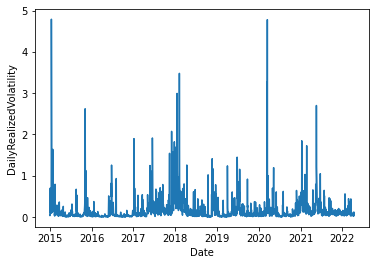

In [251]:
sns.lineplot(
    data = full_data,
    y = "DailyRealizedVolatility",
    x = "Date"
)

In [252]:
full_data.describe()

,LiteCoinPrice,DailyRealizedVolatility,WeeklyRealizedVolatility,MonthlyRealizedVolatility
count,1902.000000,1902.000000,1902.000000,1902.000000
mean,12373.002555,0.168971,0.169731,0.170443
std,16673.467489,0.327811,0.245631,0.171535
min,181.090000,0.001971,0.004162,0.010382
25%,700.962500,0.030585,0.044984,0.067002
50%,6592.925000,0.073015,0.098153,0.112010
75%,11169.962500,0.168414,0.188612,0.218673
max,67738.180000,4.791680,3.004687,0.964123


In [278]:
# Расширенная модель с VIX и EPU, h = 1
const_array = [1 for i in range(len(daily_rv_without_weekend))]
lag = 1

X_extended = pd.DataFrame({
    "Const": const_array[:-lag],
    "DailyRV": daily_rv_without_weekend[:-lag],
    "WeeklyRV": weekly_rv_without_weekend[:-lag],
    "MonthlyRV": monthly_rv_without_weekend[:-lag],
    # "VIX": vix_index[:-lag],
    # "OVX": oil_index[:-lag],
    # "GVZ": gold_index[:-lag],
    # "DJIA": djia_index[:-lag],
})

daily_rv_lag = daily_rv_without_weekend[lag:]

extended_har_rv = sm.OLS(daily_rv_lag, X_extended)
extended_har_rv = extended_har_rv.fit()

print(extended_har_rv.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     211.6
Date:                Sun, 22 May 2022   Prob (F-statistic):          2.09e-118
Time:                        18:10:34   Log-Likelihood:                -302.72
No. Observations:                1901   AIC:                             613.4
Df Residuals:                    1897   BIC:                             635.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const          0.0402      0.009      4.373      0.0

In [253]:
lag = 1
estimation_period = 1200

daily_rv_lag = daily_rv_without_weekend[lag:]
daily_rv = daily_rv_without_weekend[:-lag]
weekly_rv = weekly_rv_without_weekend[:-lag]
monthly_rv = monthly_rv_without_weekend[:-lag]
epu = epu_without_weekend[:-lag]
djia = djia_index[:-lag]
oil = oil_index[:-lag]
gold = gold_index[:-lag]
vix = vix_index[:-lag]
const = [1] * len(daily_rv)

forecasts = pd.DataFrame({
    "Realized": daily_rv_lag[estimation_period:],
})


In [254]:
base_forecast = []

for forecasting_day in range(estimation_period, len(daily_rv)):
    X = pd.DataFrame({
        "Const": const[forecasting_day - estimation_period:forecasting_day],
        "DailyRV": daily_rv[forecasting_day - estimation_period:forecasting_day],
        "WeeklyRV": weekly_rv[forecasting_day - estimation_period:forecasting_day],
        "MonthlyRV": monthly_rv[forecasting_day - estimation_period:forecasting_day],
    })

    y = daily_rv_lag[forecasting_day - estimation_period:forecasting_day]

    reg = LinearRegression().fit(X, y)

    X_for_prediction = pd.DataFrame({
        "Const": [const[forecasting_day]],
        "DailyRV": [daily_rv[forecasting_day]],
        "WeeklyRV": [weekly_rv[forecasting_day]],
        "MonthlyRV": [monthly_rv[forecasting_day]],
    })

    prediction = reg.predict(X_for_prediction) 
    base_forecast.append(prediction[0])

forecasts["Base"] = base_forecast

In [255]:
gold_forecast = []

for forecasting_day in range(estimation_period, len(daily_rv)):
    X = pd.DataFrame({
        "Const": const[forecasting_day - estimation_period:forecasting_day],
        "DailyRV": daily_rv[forecasting_day - estimation_period:forecasting_day],
        "WeeklyRV": weekly_rv[forecasting_day - estimation_period:forecasting_day],
        "MonthlyRV": monthly_rv[forecasting_day - estimation_period:forecasting_day],
        "Gold": gold[forecasting_day - estimation_period:forecasting_day],
    })

    y = daily_rv_lag[forecasting_day - estimation_period:forecasting_day]

    reg = LinearRegression().fit(X, y)

    X_for_prediction = pd.DataFrame({
        "Const": [const[forecasting_day]],
        "DailyRV": [daily_rv[forecasting_day]],
        "WeeklyRV": [weekly_rv[forecasting_day]],
        "MonthlyRV": [monthly_rv[forecasting_day]],
        "Gold": [gold[forecasting_day]],
    })

    prediction = reg.predict(X_for_prediction) 
    gold_forecast.append(prediction[0])

forecasts["Gold"] = gold_forecast

In [256]:
oil_forecast = []

for forecasting_day in range(estimation_period, len(daily_rv)):
    X = pd.DataFrame({
        "Const": const[forecasting_day - estimation_period:forecasting_day],
        "DailyRV": daily_rv[forecasting_day - estimation_period:forecasting_day],
        "WeeklyRV": weekly_rv[forecasting_day - estimation_period:forecasting_day],
        "MonthlyRV": monthly_rv[forecasting_day - estimation_period:forecasting_day],
        "Oil": oil[forecasting_day - estimation_period:forecasting_day],
    })

    y = daily_rv_lag[forecasting_day - estimation_period:forecasting_day]

    reg = LinearRegression().fit(X, y)

    X_for_prediction = pd.DataFrame({
        "Const": [const[forecasting_day]],
        "DailyRV": [daily_rv[forecasting_day]],
        "WeeklyRV": [weekly_rv[forecasting_day]],
        "MonthlyRV": [monthly_rv[forecasting_day]],
        "Oil": [oil[forecasting_day]],
    })

    prediction = reg.predict(X_for_prediction) 
    oil_forecast.append(prediction[0])

forecasts["Oil"] = oil_forecast

In [257]:
djia_forecast = []

for forecasting_day in range(estimation_period, len(daily_rv)):
    X = pd.DataFrame({
        "Const": const[forecasting_day - estimation_period:forecasting_day],
        "DailyRV": daily_rv[forecasting_day - estimation_period:forecasting_day],
        "WeeklyRV": weekly_rv[forecasting_day - estimation_period:forecasting_day],
        "MonthlyRV": monthly_rv[forecasting_day - estimation_period:forecasting_day],
        "Djia": djia[forecasting_day - estimation_period:forecasting_day],
    })

    y = daily_rv_lag[forecasting_day - estimation_period:forecasting_day]

    reg = LinearRegression().fit(X, y)

    X_for_prediction = pd.DataFrame({
        "Const": [const[forecasting_day]],
        "DailyRV": [daily_rv[forecasting_day]],
        "WeeklyRV": [weekly_rv[forecasting_day]],
        "MonthlyRV": [monthly_rv[forecasting_day]],
        "Djia": [djia[forecasting_day]],
    })

    prediction = reg.predict(X_for_prediction) 
    djia_forecast.append(prediction[0])

forecasts["Djia"] = djia_forecast

In [258]:
epu_forecast = []

for forecasting_day in range(estimation_period, len(daily_rv)):
    X = pd.DataFrame({
        "Const": const[forecasting_day - estimation_period:forecasting_day],
        "DailyRV": daily_rv[forecasting_day - estimation_period:forecasting_day],
        "WeeklyRV": weekly_rv[forecasting_day - estimation_period:forecasting_day],
        "MonthlyRV": monthly_rv[forecasting_day - estimation_period:forecasting_day],
        "Epu": epu[forecasting_day - estimation_period:forecasting_day],
    })

    y = daily_rv_lag[forecasting_day - estimation_period:forecasting_day]

    reg = LinearRegression().fit(X, y)

    X_for_prediction = pd.DataFrame({
        "Const": [const[forecasting_day]],
        "DailyRV": [daily_rv[forecasting_day]],
        "WeeklyRV": [weekly_rv[forecasting_day]],
        "MonthlyRV": [monthly_rv[forecasting_day]],
        "Epu": [epu[forecasting_day]],
    })

    prediction = reg.predict(X_for_prediction) 
    epu_forecast.append(prediction[0])

forecasts["Epu"] = epu_forecast

In [259]:
vix_forecast = []

for forecasting_day in range(estimation_period, len(daily_rv)):
    X = pd.DataFrame({
        "Const": const[forecasting_day - estimation_period:forecasting_day],
        "DailyRV": daily_rv[forecasting_day - estimation_period:forecasting_day],
        "WeeklyRV": weekly_rv[forecasting_day - estimation_period:forecasting_day],
        "MonthlyRV": monthly_rv[forecasting_day - estimation_period:forecasting_day],
        "Vix": vix[forecasting_day - estimation_period:forecasting_day],
    })

    y = daily_rv_lag[forecasting_day - estimation_period:forecasting_day]

    reg = LinearRegression().fit(X, y)

    X_for_prediction = pd.DataFrame({
        "Const": [const[forecasting_day]],
        "DailyRV": [daily_rv[forecasting_day]],
        "WeeklyRV": [weekly_rv[forecasting_day]],
        "MonthlyRV": [monthly_rv[forecasting_day]],
        "Vix": [vix[forecasting_day]],
    })

    prediction = reg.predict(X_for_prediction) 
    vix_forecast.append(prediction[0])

forecasts["Vix"] = vix_forecast

In [260]:
name_of_file = f'LTC_vf_w{estimation_period}_l{lag}'
forecasts.to_csv(name_of_file)

In [270]:
forecasts_plot = pd.DataFrame({
    "Date": dates_without_weekend[-len(base_forecast):],
    "RealizedV": daily_rv_without_weekend[-len(base_forecast):],
    "Gold": base_forecast,
})

<AxesSubplot:>

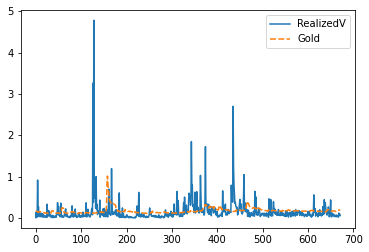

In [271]:
sns.lineplot(
    data = forecasts_plot
)